In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import math
import plotly.express as px

In [2]:
# Import our adaptive module:
from adaptive import Adaptive

In [3]:
# An experiment:

In [4]:
### Initial parameters
mu = 0.00015
gamma = 0.1823
beta = 0.0925
phi = 0.0044

### Adaptive parameters
bi = 6.67
bz = 10
bs = 10
ai = 1.826
az = 0
as1 = 0 
gamma1 = 0.25
tau = 12
delta = 0.99986

### Simulation parameters
t_max = 300
steps = 10
x00 = [0.7, 0.01, 0.29]
# Note: our start point is not [1,0,0]
# Because the disease-free equilibrium is stable for models with demographics.

In [11]:
0.5*bi*beta/(gamma+mu)

1.6908057001918333

In [5]:
# Initialize adaptive instances
instance_adaptive = Adaptive(mu, gamma, beta, phi,
                             bs, bi, bz, 
                             as1, ai, az,
                             gamma1, tau, delta,
                             t_max, steps, x00)

In [6]:
start = time.time()
instance_adaptive.patch_uni_solutions()
end = time.time()
print(f"Running the adaptive algorithm took {end - start} seconds.")

C:\Users\jimmy\OneDrive\Desktop\Maestria Metodos Matematicos y Aplicaciones\Tesis\adaptive\design\adaptive\adaptive.py:162: RuntimeWarning: divide by zero encountered in double_scalars
  expr1 = (self.gamma1*(self.bs*C_st - C_st**2)**(self.gamma1 - 1) + self.bs -2*C_st) / expr0


Running the adaptive algorithm took 16.599148273468018 seconds.


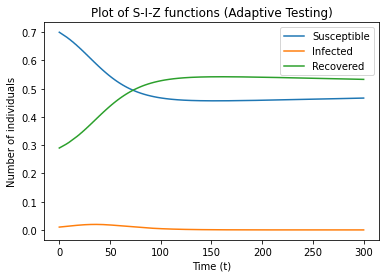

In [7]:
t = np.linspace(0, instance_adaptive.t_max, len(instance_adaptive.S))
instance_adaptive.plot_ode_solution(t = t, title = 'Adaptive Testing')

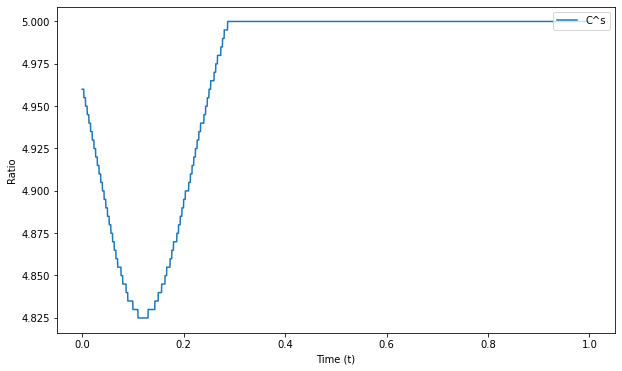

In [8]:
cs_unistep = []
for i in range(len(instance_adaptive.Cs)):
    cs_unistep = cs_unistep + [instance_adaptive.Cs[i]]*steps
    
plt.plot(np.linspace(0,1,len(cs_unistep)), cs_unistep, label="C^s")
plt.xlabel("Time (t)")
plt.ylabel("Ratio")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

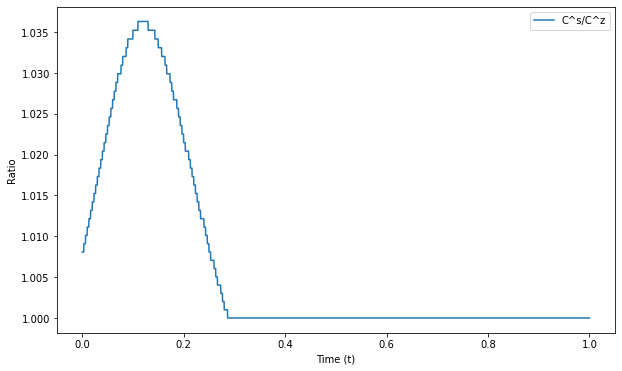

In [9]:
cs_unistep = []
for i in range(len(instance_adaptive.Cs)):
    cs_unistep = cs_unistep + [0.5*instance_adaptive.bz/instance_adaptive.Cs[i]]*steps
    
plt.plot(np.linspace(0,1,len(cs_unistep)), cs_unistep, label="C^s/C^z")
plt.xlabel("Time (t)")
plt.ylabel("Ratio")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

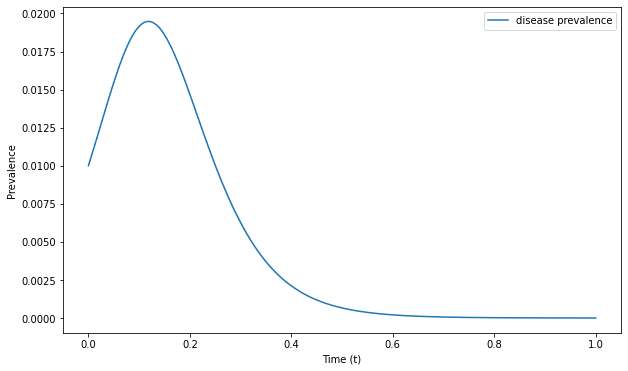

In [10]:
plt.plot(np.linspace(0,1,len(instance_adaptive.I)), instance_adaptive.I, label="disease prevalence")
plt.xlabel("Time (t)")
plt.ylabel("Prevalence")
plt.legend(loc = "upper right")
plt.rcParams["figure.figsize"] = (10,6)
plt.show()